## Q-Learning for gym's MountainCar (using a Neural Network)
[OpenAI gym MountainCar](https://gym.openai.com/envs/MountainCar-v0/)<br>
This code implements a Neural Network to learn the environment MountainCar. It's a Q-Learning algorithm and not a DQN so it does not count with another network (Q-target) and no Experience Replay.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import gym
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.tensorboard import SummaryWriter

Number of possible actions: 3
Number of possible states: Box(2,)


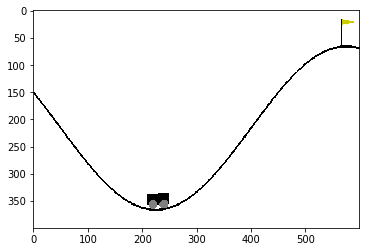

In [2]:
env = gym.make("MountainCar-v0").env
# The .env is to avoid for MountainCar to stop the game after 200 episodes.
# https://stackoverflow.com/a/42802225/4512032
# https://github.com/openai/gym/blob/c7f9edf943174387b2336ec7f7bc15e0ecac16f8/gym/envs/registration.py#L110

print("Number of possible actions:", env.action_space.n)
print("Number of possible states:", env.observation_space)

env.reset()
plt.imshow(env.render("rgb_array"))

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
class qAgent:
    def __init__(self, n_action_space, n_observation_space, epsilon, alpha, discount_factor):
        self.n_action_space = n_action_space
        self.n_observation_space = n_observation_space
        
        self.epsilon = epsilon
        self.alpha = alpha
        self.discount_factor = discount_factor
        
        self.qnetwork = nn.Sequential(
                    nn.Linear(n_observation_space[0], 128),
                    nn.ReLU(),
                    nn.Linear(128, 256),
                    nn.ReLU(),
                    nn.Linear(256, n_action_space)
        ).to(device)
        
    def get_action_epsilon_greedy(self, state):    
        # the action returned either will be random or the greedy
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.n_action_space) # return a random action
        else: # else, be greedy
            state = torch.tensor(state, dtype=torch.float32, device=device)
            qvalues = self.qnetwork(state).detach() # returns a new Tensor, detached from the current graph.
            action = torch.argmax(qvalues).item() 
        return action
    
    def get_greedy_action(self, state):
        state = torch.tensor(state, dtype=torch.float32, device=device)
        qvalues = self.qnetwork(state).detach() # returns a new Tensor, detached from the current graph.
        action = torch.argmax(qvalues).item() 
        return action
    
    def get_qvalues(self, state):
        return self.qnetwork(state)
   
    def calculate_loss(self, state, action, new_state, reward, done):
        # convert variables to tensor
        state = torch.tensor(state, dtype=torch.float32, device=device)
        new_state = torch.tensor(new_state, dtype=torch.float32, device=device)
        reward = torch.tensor(reward, dtype=torch.float32, device=device)
        not_done = 1 - done

        # predict all q-values for current state
        all_qvalues_state = self.get_qvalues(state)
       
        # select the q_value for the agent action
        qvalue_state = all_qvalues_state[action]
        
        # predict all q-values for the new state 
        all_qvalues_new_state = self.get_qvalues(new_state)
       
        # index of action that maximizes the new state q(s,a)
        argmax_new_action = torch.argmax(all_qvalues_new_state)
        # select the q-value for the new state for the action that maximises it, q'(s',amax)
        qvalue_new_state =  all_qvalues_new_state[argmax_new_action]
        
 
        # if it's a terminal state (done) the target receives only the value of the reward
        max_qvalue_new_state = reward + self.discount_factor*qvalue_new_state*not_done

        # loss = MSE (mean squared error) between Q-network and Q-learning targets
        # the detach is a way to fix the network by not having their gradients computed
        loss = F.mse_loss(max_qvalue_new_state.detach(), qvalue_state)
        
        return loss

In [5]:
# hyperparameters
epsilon_init = 0.8
epsilon_end = 0.1

alpha = 0.5
discount_factor = 0.99

agent = qAgent(n_action_space=env.action_space.n,
               n_observation_space=env.observation_space.shape,
               epsilon=epsilon_init,
               alpha=alpha,
               discount_factor=discount_factor)


In [6]:
learning_rate = 0.0001
optimiser = torch.optim.Adam(agent.qnetwork.parameters(), lr=learning_rate)

In [7]:
# writter for tensorboard
writer = SummaryWriter()
# to see the board run on terminal the following command:
# tensorboard --logdir=runs

In [8]:
def train(env, n_epochs=1000, reward_position=False):
    rewards_history = []
    positions_history = []
    score = []
    
    # constant to decrement the value of epsilon
    epsilon_decrement = (epsilon_init - epsilon_end)/n_epochs
    
    for epoch in range(n_epochs):
        positions_episode = []

        rewards_episode = 0
        state = env.reset()
        done = False
        for step in range(2000):
            action = agent.get_action_epsilon_greedy(state)

            new_state, reward, done, info = env.step(action)
            
            rewards_episode += reward
            position = new_state[0] + 0.5
            positions_episode.append(position)

            loss = agent.calculate_loss(state, action, new_state, reward, done)
                
            loss.backward()
            optimiser.step()
            optimiser.zero_grad()

            state = new_state
            
            if done:
                if position >= env.goal_position: # arrived at the position goal?
                    score.append(1)
                    break
                else:
                    score.append(0)
                    
        writer.add_scalar('Reward/Train', rewards_episode, epoch)

        if epoch%50 == 0:
            print("Epoch={} \t epsilon={:.2f}\t score={}/{}\t rewards={:.2f}".format(epoch+1, agent.epsilon, score.count(1), len(score), rewards_episode))
            
            
        rewards_history.append(rewards_episode)
        positions_history.append(positions_episode)
        
        agent.epsilon -= epsilon_decrement
            
    return rewards_history, score

In [9]:
rewards, _ = train(env, n_epochs=2000, reward_position=True)

Epoch=1 	 epsilon=0.80	 score=1/1	 rewards=-1091.00
Epoch=51 	 epsilon=0.78	 score=2/2	 rewards=-2000.00
Epoch=101 	 epsilon=0.77	 score=2/2	 rewards=-2000.00
Epoch=151 	 epsilon=0.75	 score=2/2	 rewards=-2000.00
Epoch=201 	 epsilon=0.73	 score=2/2	 rewards=-2000.00
Epoch=251 	 epsilon=0.71	 score=28/28	 rewards=-697.00
Epoch=301 	 epsilon=0.70	 score=67/67	 rewards=-320.00
Epoch=351 	 epsilon=0.68	 score=99/99	 rewards=-541.00
Epoch=401 	 epsilon=0.66	 score=145/145	 rewards=-518.00
Epoch=451 	 epsilon=0.64	 score=195/195	 rewards=-409.00
Epoch=501 	 epsilon=0.63	 score=245/245	 rewards=-1164.00
Epoch=551 	 epsilon=0.61	 score=293/293	 rewards=-279.00
Epoch=601 	 epsilon=0.59	 score=343/343	 rewards=-248.00
Epoch=651 	 epsilon=0.57	 score=393/393	 rewards=-423.00
Epoch=701 	 epsilon=0.56	 score=443/443	 rewards=-294.00
Epoch=751 	 epsilon=0.54	 score=493/493	 rewards=-327.00
Epoch=801 	 epsilon=0.52	 score=543/543	 rewards=-634.00
Epoch=851 	 epsilon=0.50	 score=593/593	 rewards=-259.

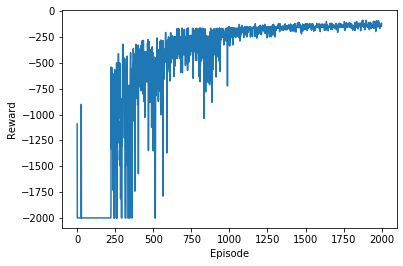

In [10]:
plt.plot(rewards)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

In [11]:
# play some episodes to see how it's working 
from time import sleep

agent.qnetwork.eval() # set model to evaluation mode
#https://discuss.pytorch.org/t/model-eval-vs-with-torch-no-grad/19615/2

with torch.no_grad():
    for i in range(3):
        state = env.reset()
        done = False
        reward_sum = 0
        while not done:
            env.render()
            #state = torch.tensor(state, dtype=torch.float32, device=device)
            action = agent.get_greedy_action(state)

            state, reward, done, _ = env.step(action)
            reward_sum += reward

            sleep(0.01)
        print("Episode finished. Reward={:.4f}".format(reward_sum))

Episode finished. Reward=-173.0000
Episode finished. Reward=-113.0000
Episode finished. Reward=-138.0000


In [13]:
torch.save(agent.qnetwork.state_dict(), "./agents/Q-Learning-MountainCar.pt")